In [1]:
import pandas as pd

gene_encodings = pd.read_csv("Gene_freq_encoding.csv")

In [2]:
gene_encodings.shape

(3364, 30546)

In [3]:
gene_encodings.head(10)

,Unnamed: 0,DonorIDs,CancerType,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,...,ENSG00000273456,ENSG00000273466,ENSG00000273471,ENSG00000273476,ENSG00000273477,ENSG00000273478,ENSG00000273483,ENSG00000273485,ENSG00000273488,ENSG00000273489
0,0,DO48566BLCA-US,BLCA-US,0.0,0.0,0.0,2.0,3.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,DO223588BLCA-US,BLCA-US,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,DO51948BLCA-US,BLCA-US,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,DO514BLCA-US,BLCA-US,0.0,0.0,0.0,0.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,DO474BLCA-US,BLCA-US,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,DO481BLCA-US,BLCA-US,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6,DO48576BLCA-US,BLCA-US,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,DO219068BLCA-US,BLCA-US,0.0,0.0,0.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8,DO51906BLCA-US,BLCA-US,0.0,0.0,4.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,9,DO48611BLCA-US,BLCA-US,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
cancer_types = set(gene_encodings["CancerType"])
cancer_types

{'BLCA-US',
 'BRCA-US',
 'COAD-US',
 'GBM-US',
 'KIRC-US',
 'LGG-US',
 'LUSC-US',
 'OV-US',
 'PRAD-US',
 'SKCM-US',
 'THCA-US',
 'UCEC-US'}

In [5]:
label_dict = {}

for i, ct in enumerate(cancer_types):
    label_dict[ct] = i
label_dict

{'UCEC-US': 0,
 'BLCA-US': 1,
 'GBM-US': 2,
 'KIRC-US': 3,
 'LGG-US': 4,
 'OV-US': 5,
 'PRAD-US': 6,
 'LUSC-US': 7,
 'SKCM-US': 8,
 'COAD-US': 9,
 'THCA-US': 10,
 'BRCA-US': 11}

In [6]:
gene_labels = [label for label in gene_encodings.columns if label.startswith("ENSG")]
len(gene_labels)

30543

In [7]:
datax = gene_encodings[gene_labels].to_numpy()
datax.shape

(3364, 30543)

In [8]:
import numpy as np
def to_categorical(val, n_class=12):
    result = np.zeros(n_class)
    result[val] = 1
    return result

In [9]:
datay = [to_categorical(label_dict[t]) for t in list(gene_encodings['CancerType'])]
datay = np.array(datay)
datay.shape

(3364, 12)

In [10]:
datay[:5]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [11]:
from sklearn.decomposition import TruncatedSVD

reducer = TruncatedSVD(n_components=2)
reduced = reducer.fit_transform(datax)

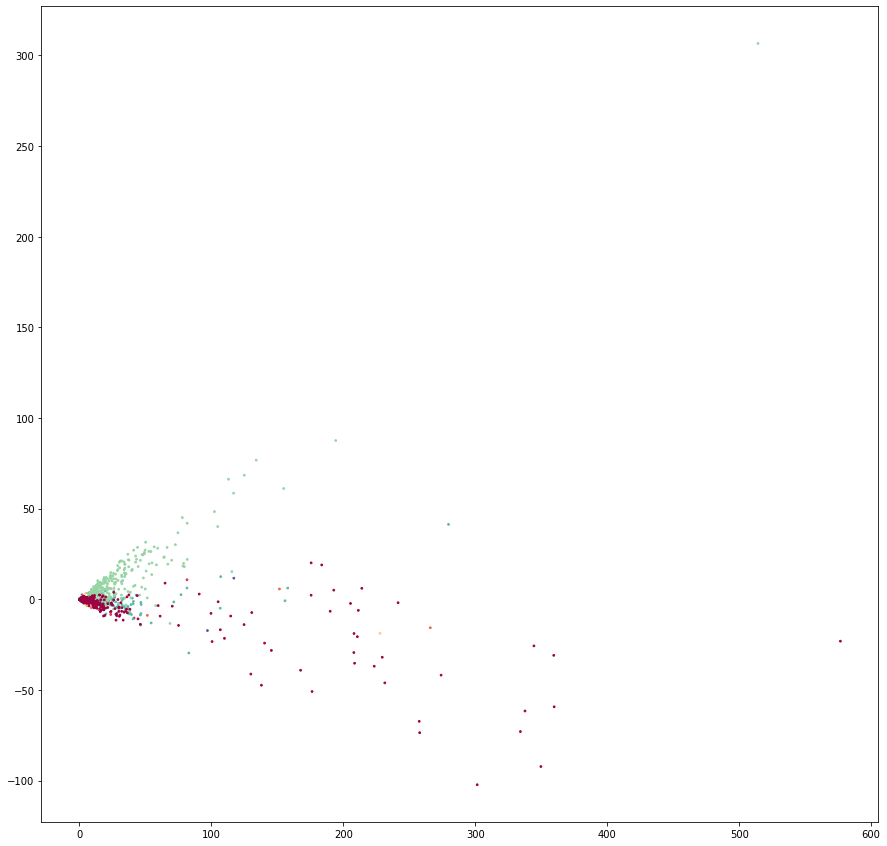

In [12]:
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

plt.rcParams["figure.figsize"] = (15, 15)
cancer_labels = [label_dict[t] for t in list(gene_encodings["CancerType"])]
plt.scatter(reduced[:, 0], reduced[:, 1], s=3, cmap="Spectral", c=cancer_labels)
plt.show()

In [13]:
import umap

In [14]:
umap_reducer = umap.UMAP(n_neighbors=25)
umap_reduced = umap_reducer.fit_transform(datax)

/home/lava-gpu/anaconda3/envs/ml-lava/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../anaconda3/envs/ml-lava/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/lava-gpu/anaconda3/envs/ml-lava/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../anaconda3/envs/ml-lava/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  state.func_ir.loc))
/home/lava-gpu/anaconda3/envs/ml-lava/lib/python3.7/sit

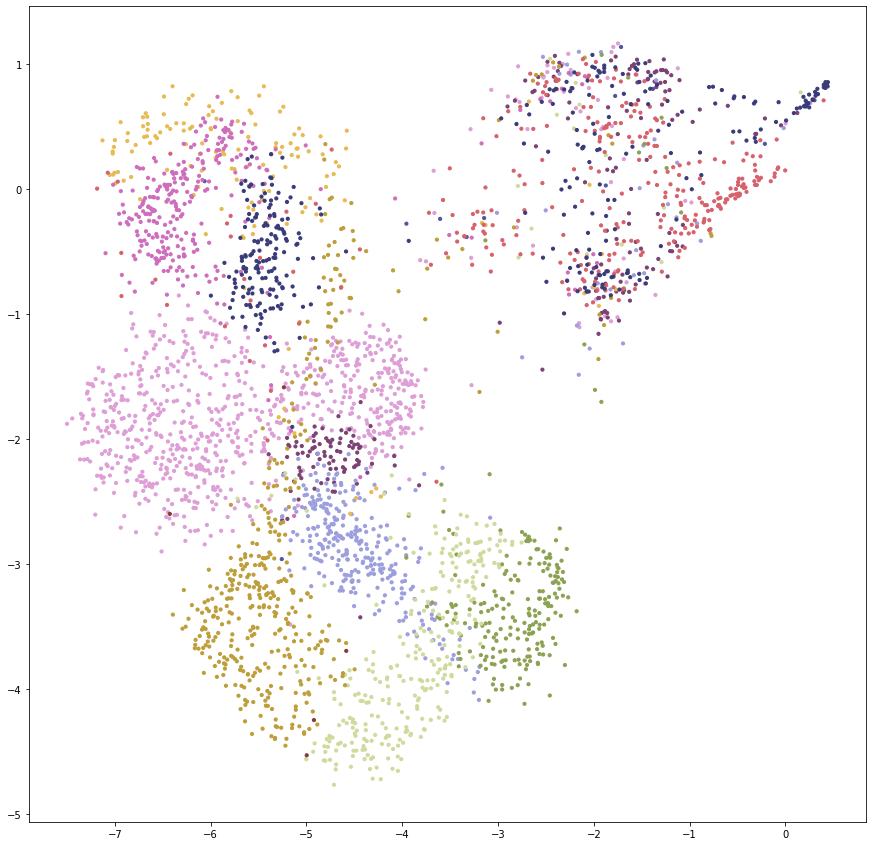

In [15]:
plt.scatter(umap_reduced[:, 0], umap_reduced[:, 1], s=10, cmap="tab20b", c=cancer_labels)
plt.show()

In [16]:
umap_3d = umap.UMAP(n_neighbors=15, n_components=3)
umap_reduced_3d = umap_3d.fit_transform(datax)

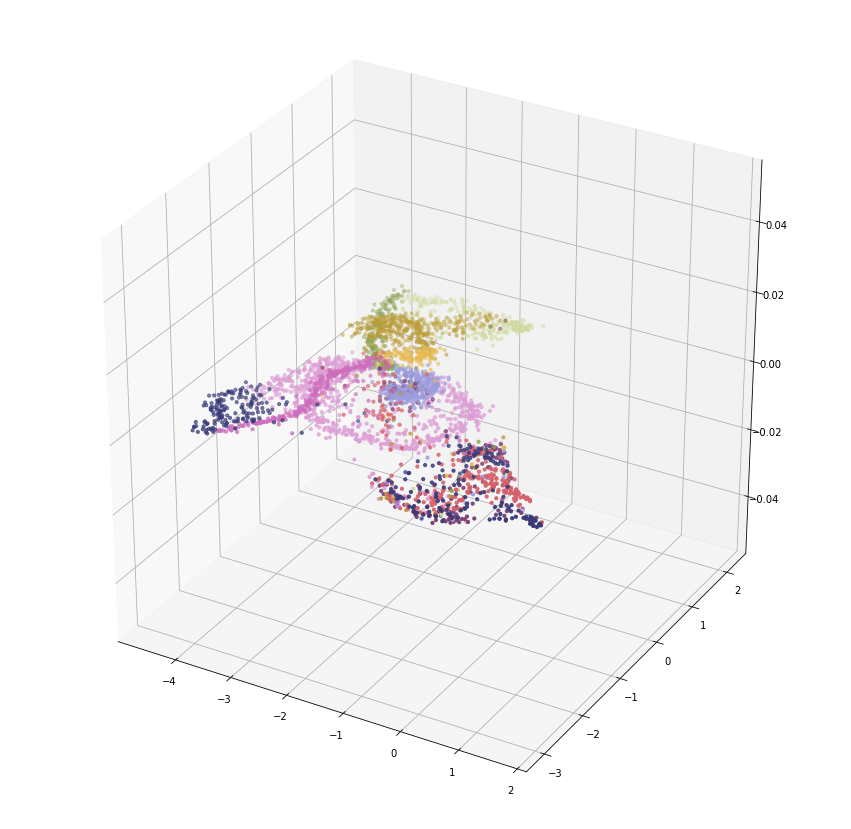

In [17]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=umap_reduced_3d[:, 0], ys=umap_reduced_3d[:, 1], s=10, cmap='tab20b', c=cancer_labels)
plt.show()

In [18]:
umap_300 = umap.UMAP(n_components=300)
umap_reduced_300 = umap_300.fit_transform(datax)

In [40]:
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

X = Input((300,))
H1 = Dense(150)(X)
B1 = BatchNormalization()(H1)
Z1 = Activation("relu")(B1)
D1 = Dropout(0.1)(Z1)
H2 = Dense(75)(D1)
B2 = BatchNormalization()(H2)
Z2 = Activation("relu")(B2)
D2 = Dropout(0.1)(Z2)
H3 = Dense(32)(D2)
B3 = BatchNormalization()(H3)
Z3 = Activation("relu")(H3)
D3 = Dropout(0.1)(Z3)
Y = Dense(12, activation="softmax")(D3)

model = Model(X, Y)

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 300)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 150)               45150     
_________________________________________________________________
batch_normalization_v1 (Batc (None, 150)               600       
_________________________________________________________________
activation_12 (Activation)   (None, 150)               0         
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 75)                11325     
___________________________

In [21]:
merged_data = [(umap_reduced_300[i],datay[i]) for i in range(datay.shape[0])]

In [23]:
np.random.shuffle(merged_data)

In [41]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.00003), metrics=["accuracy"])


In [25]:
test = merged_data[:500]
train = merged_data[500:]

In [26]:
trainx = np.array([x for (x,_) in train])
trainy = np.array([y for (_,y) in train])

In [42]:
model.fit(trainx, trainy, batch_size=32, epochs=100, validation_split=0.2)

Train on 2291 samples, validate on 573 samples
Epoch 1/100
2291/2291 [==============================] - 1s 437us/sample - loss: 2.7424 - acc: 0.0746 - val_loss: 2.5049 - val_acc: 0.0087
Epoch 2/100
2291/2291 [==============================] - 1s 233us/sample - loss: 2.4111 - acc: 0.1340 - val_loss: 2.4338 - val_acc: 0.0052
Epoch 3/100
2291/2291 [==============================] - 1s 229us/sample - loss: 2.1923 - acc: 0.2082 - val_loss: 2.2857 - val_acc: 0.1257
Epoch 4/100
2291/2291 [==============================] - 1s 241us/sample - loss: 2.0318 - acc: 0.2772 - val_loss: 2.0849 - val_acc: 0.3508
Epoch 5/100
2291/2291 [==============================] - 1s 233us/sample - loss: 1.8726 - acc: 0.3701 - val_loss: 1.8778 - val_acc: 0.5462
Epoch 6/100
2291/2291 [==============================] - 1s 236us/sample - loss: 1.7609 - acc: 0.4478 - val_loss: 1.6896 - val_acc: 0.6754
Epoch 7/100
2291/2291 [==============================] - 1s 229us/sample - loss: 1.6551 - acc: 0.5007 - val_loss: 1.529

2291/2291 [==============================] - 1s 231us/sample - loss: 0.5682 - acc: 0.8162 - val_loss: 0.4298 - val_acc: 0.8586
Epoch 60/100
2291/2291 [==============================] - 1s 229us/sample - loss: 0.5635 - acc: 0.8158 - val_loss: 0.4269 - val_acc: 0.8569
Epoch 61/100
2291/2291 [==============================] - 1s 233us/sample - loss: 0.5589 - acc: 0.8258 - val_loss: 0.4264 - val_acc: 0.8586
Epoch 62/100
2291/2291 [==============================] - 1s 240us/sample - loss: 0.5653 - acc: 0.8158 - val_loss: 0.4235 - val_acc: 0.8569
Epoch 63/100
2291/2291 [==============================] - 1s 233us/sample - loss: 0.5485 - acc: 0.8228 - val_loss: 0.4213 - val_acc: 0.8604
Epoch 64/100
2291/2291 [==============================] - 1s 232us/sample - loss: 0.5489 - acc: 0.8202 - val_loss: 0.4209 - val_acc: 0.8586
Epoch 65/100
2291/2291 [==============================] - 1s 233us/sample - loss: 0.5543 - acc: 0.8215 - val_loss: 0.4206 - val_acc: 0.8604
Epoch 66/100
2291/2291 [=========

In [34]:
testx = np.array([x for (x,_) in test])
testy = np.array([y for (_,y) in test])


In [43]:
model.evaluate(testx, testy)

500/500 [==============================] - 0s 71us/sample - loss: 0.4422 - acc: 0.8560


[0.4422239046096802, 0.856]